# Tutorial 8a - Tolerancing, Sensitivity Analyses

### September 2024

In this tutorial, we will explore the process of tolerancing an optical system in Optiland via sensitivity analysis. Tolerancing is a crucial aspect of optical design, ensuring that the system performs adequately despite manufacturing imperfections. Sensitivity analysis helps in understanding how variations in design parameters affect the overall performance of the optical system.

Tolerancing in Optiland requires 4 key components:

1. Optic - the optical system to be analyzed.
2. Operands - the metrics which are assessed e.g., wavefront error.
3. Perturbations - the variations applied to the optic or a surface of an optic e.g., surface tilt.
4. Compensators - a parameter of the optical system that can be adjusted to counteract the effects of a perturbation.

In this example, we will apply various perturbations to our optic, one at a time, while monitoring various metrics, or operands. We will perform a sensitivity analysis, which will show the variation in each metric (operand) as a function of each perturbation. In this case, all perturbations are applied independently.

In [1]:
from optiland.samples.objectives import CookeTriplet
from optiland.tolerancing import RangeSampler, SensitivityAnalysis, Tolerancing

1. Defining the tolerancing object:

The core of tolerancing in Optiland is the Tolerancing class. This class contains all operands, perturbations and compensators that are used during a tolerancing exercise. We start by defining a Cooke triplet and passing it to our Tolerancing class.

In [2]:
optic = CookeTriplet()

In [3]:
tolerancing = Tolerancing(optic)

2. Adding perturbations


Each tolerancing object contains perturbations, or variations that are applied to the optic during a tolerancing analysis. Each perturbation requires a value that should be applied to the perturbation. For example, we may wish to tilt the first surface by 0.01 radians. The values of a given perturbation are specified via "samplers", which provide the perturbation value in each iteration. We define a "RangeSampler", in which perturbation values are defined in a linear range from a "start" value to a "end" value over a given number of "steps".

For the first perturbation, we wish to specify the following properties:

- Variation in radius of curvature of first surface of lens
- Variation occurs from 15 mm to 30 mm over 128 steps

This is defined and added to our tolerancing instance as follows:

In [4]:
sampler = RangeSampler(start=15, end=30, steps=128)
tolerancing.add_perturbation("radius", sampler, surface_number=1)

For the next perturbation, we will apply a variation of x-tilt to the first surface:

In [5]:
sampler = RangeSampler(start=-0.05, end=0.05, steps=128)  # radians
tolerancing.add_perturbation("tilt", sampler, surface_number=1, axis="x")

For the last perturbation, we will vary the thickness of our first lens (at surface 1):

In [6]:
sampler = RangeSampler(start=2, end=5, steps=128)
tolerancing.add_perturbation("thickness", sampler, surface_number=1)

3. Adding operands

When we apply perturbations, we want to monitor various performance metrics. Here, we will monitor:

- focal length
- RMS spot size
- mean OPD difference

The syntax used here follows that used in the optimization module when variables are defined. In general, we pass the following arguments to the "add_operand" method to create a new operand:

- operand type - see optiland.optimization.operand for complete list of options.
- input_data - a dictionary containing the optic instance at a minimum, and generally other parameters related to the operand, such as wavelength.
- target (optional) - if an operand has a target, we may specify it here. This is only used when we apply compensation, or optimize the system to counteract perturbations.
- weight (optional) - if an operand is more important than others, it may be given a larger weight during compensation.

We define the 3 operands as follows:

In [7]:
input_data = {"optic": optic}
tolerancing.add_operand("f2", input_data)

input_data = {
    "optic": optic,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0.0,
    "wavelength": 0.55,
    "num_rays": 5,
}  # surface_number=-1 means the last surface
tolerancing.add_operand("rms_spot_size", input_data, target=0)

input_data = {"optic": optic, "Hx": 0, "Hy": 1, "wavelength": 0.55, "num_rays": 5}
tolerancing.add_operand("OPD_difference", input_data)

4. Run sensitivity analysis


The next step is to pass our tolerancing variable to a "SensitivityAnalysis" instance. This class performs all sensitivity operations, saves the results, and provides an interface to view the results.

In [8]:
sensitivity_analysis = SensitivityAnalysis(tolerancing)

And we can now run the analysis. The duration of the analysis will depend on the number of operands, perturbations and their ranges, as well as whether compensators are applied. On the author's machine, this analysis takes a couple seconds (for ≈400 evaluations in total).

In [9]:
sensitivity_analysis.run()

5. View and analyze results


We can call the "view" method of SensitivityAnalysis to show effect of the perturbations on the operands:

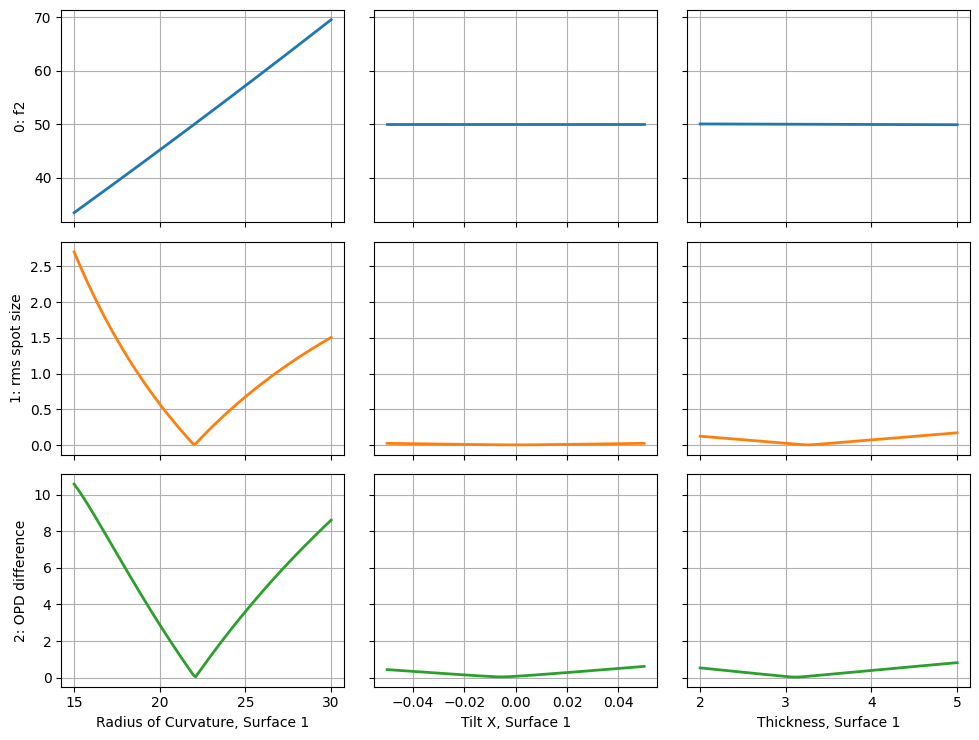

In [10]:
sensitivity_analysis.view()

As we defined 3 operands and 3 perturbations, we see a collection of 9 (3x3) plots. The rows represent the operands and the columns represent the perturbations. A few relationships we can observe:

- the strongest effect by far is perturbation of the radius of curvature
- the RMS spot size and OPD difference are a minimum at the nominal radius of curvature value (≈22mm)
- tilting or changing the thickness of surface 1 has little impact on the focal length
- tilt has a small impact on the OPD difference, with a minimum near 0 radians

Lastly, if we wish to further analyze the results, we can retrieve all results via the "get_results" method, which returns a pandas DataFrame.

In [11]:
df = sensitivity_analysis.get_results()

In [12]:
df.head()

,perturbation_type,perturbation_value,0: f2,1: rms spot size,2: OPD difference
0,"Radius of Curvature, Surface 1",15.000000,33.469945,2.701670,10.590084
1,"Radius of Curvature, Surface 1",15.118110,33.743491,2.634001,10.438667
2,"Radius of Curvature, Surface 1",15.236220,34.017200,2.567470,10.281144
3,"Radius of Curvature, Surface 1",15.354331,34.291071,2.502048,10.118328
4,"Radius of Curvature, Surface 1",15.472441,34.565104,2.437704,9.950932


In [13]:
df.describe()

,perturbation_value,0: f2,1: rms spot size,2: OPD difference
count,384.000000,384.000000,384.000000,384.000000
mean,8.666667,50.424385,0.363349,1.853603
std,10.227280,6.099911,0.585420,2.730398
min,-0.050000,33.469945,0.004343,0.028153
25%,0.025394,49.955874,0.016517,0.216752
50%,3.500000,49.999783,0.070662,0.433987
75%,18.690945,50.029381,0.479762,2.460403
max,30.000000,69.558794,2.701670,10.590084


We may also save the results to a csv file:

In [14]:
df.to_csv("sensitivity_analysis.csv")

Conclusions

- This tutorial demonstrated the basics of tolerancing in Optiland.
- Tolerancers in Optiland require:

    1) an optic
    2) operand(s)
    3) perturbation(s)
    4) (optional) compensator(s)
- A sensitivity analysis can be performed by first defining a tolerancing object, then passing it to SensitivityAnalysis and calling the "run" method.
- The results of a sensitivity analysis can be retrieved as a pandas DataFrame and saved for further analysis.